In [ ]:
import pandas as pd
df = pd.read_csv('../../../datasets/data.csv')
stable_pairs = []
non_stable_pairs = []
stable_df = df[df['stability'] == 'stable']
stable_pair_ids = stable_df['pair_id'].unique()
for pair_id in stable_pair_ids:
    pair_images = stable_df[stable_df['pair_id'] == pair_id]
    wood_image = pair_images[pair_images['image_type'] == 'wood'].iloc[0]
    clinic_image = pair_images[pair_images['image_type'] == 'clinic'].iloc[0]
    stable_pairs.append((wood_image, clinic_image))
    
non_stable_df = df[df['stability'] == 'non-stable']
non_stable_pair_ids = non_stable_df['pair_id'].unique()
for pair_id in non_stable_pair_ids:
    pair_images = non_stable_df[non_stable_df['pair_id'] == pair_id]
    wood_image = pair_images[pair_images['image_type'] == 'wood'].iloc[0]
    clinic_image = pair_images[pair_images['image_type'] == 'clinic'].iloc[0]
    non_stable_pairs.append((wood_image, clinic_image))

方向调整

In [ ]:
import pandas as pd
from PIL import Image
import os

def load_data(file_path):
    df = pd.read_csv(file_path)

    if 'image_path' not in df.columns:
        raise ValueError("CSV文件中缺少'image_path'列")
    df['orientation'] = None

    for idx, row in df.iterrows():
        image_path = row['image_path']

        if not os.path.exists(image_path):
            print(f"警告: 图像文件不存在: {image_path}")
            continue
        
        try:
            image = Image.open(image_path)
            exif = image._getexif()
            
            if exif is not None:

                for tag, value in exif.items():
                    if tag in ExifTags.TAGS and ExifTags.TAGS[tag] == 'Orientation':
                        df.at[idx, 'orientation'] = value
                        break
            else:
                print(f"提示: 图像 {image_path} 没有EXIF元数据")
                
        except Exception as e:
            print(f"错误处理图像 {image_path}: {str(e)}")

    df.to_csv('data_with_oritentation.csv', index=False)
    return df

df = load_data('../../../datasets/data.csv')


提示: 图像 stable\11-0001-20240725121302-00150.JPG 没有EXIF元数据
提示: 图像 stable\11-0002-20240827081753-00001.JPG 没有EXIF元数据
提示: 图像 stable\11-0003-20230202113446-00167.JPG 没有EXIF元数据
提示: 图像 stable\11-0004-20230202113446-00170.JPG 没有EXIF元数据
提示: 图像 stable\11-0005-20230202113446-00175.JPG 没有EXIF元数据
提示: 图像 stable\11-0006-20230202113446-00173.JPG 没有EXIF元数据
提示: 图像 stable\11-0007-20220207095056-00044.JPG 没有EXIF元数据
提示: 图像 stable\11-0008-20220222105317-00157.JPG 没有EXIF元数据
提示: 图像 stable\11-0009-20220222105317-00159.JPG 没有EXIF元数据
提示: 图像 stable\11-0010-20220222105317-00161.JPG 没有EXIF元数据
提示: 图像 stable\11-0011-20230109102144-00120.JPG 没有EXIF元数据
提示: 图像 stable\11-0012-20230109102144-00123.JPG 没有EXIF元数据
提示: 图像 stable\11-0013-20220322082233-00009.JPG 没有EXIF元数据
提示: 图像 stable\11-0014-20220322082233-00011.JPG 没有EXIF元数据
提示: 图像 stable\11-0015-20220707104124-00115.JPG 没有EXIF元数据
提示: 图像 stable\11-0016-20220811090251-00051.JPG 没有EXIF元数据
提示: 图像 stable\11-0017-20230202101109-00086.JPG 没有EXIF元数据
提示: 图像 stable\11-0018-202302021

In [16]:
df['orientation'].unique()

array([1, None, 3], dtype=object)

In [ ]:
import pandas as pd
import cv2
import os
from tqdm import tqdm
import numpy as np


def shrink(X,tau):
    Y = np.abs(X)-tau
    return np.sign(X) * np.maximum(Y,np.zeros_like(Y))
def SVT(X,tau):
    U,S,VT = np.linalg.svd(X,full_matrices=0)
    out = U @ np.diag(shrink(S,tau)) @ VT
    return out
def RPCA(X):
    n1,n2 = X.shape
    mu = n1*n2/(4*np.sum(np.abs(X.reshape(-1)))) 
    lambd = 1/np.sqrt(np.maximum(n1,n2))
    thresh = 10**(-7) * np.linalg.norm(X)
    
    S = np.zeros_like(X)
    Y = np.zeros_like(X)
    L = np.zeros_like(X)
    count = 0
    while (np.linalg.norm(X-L-S) > thresh) and (count < 1000):
        L = SVT(X-S+(1/mu)*Y,1/mu)
        S = shrink(X-L+(1/mu)*Y,lambd/mu)
        Y = Y + mu*(X-L-S)
        count += 1
    return L,S

def load_data(file_path):
    return pd.read_csv(file_path)

def extract_image_pairs(df, stability_status):

    status_df = df[df['stability'] == stability_status]
    pair_ids = status_df['pair_id'].unique()
    image_pairs = []
    for pair_id in pair_ids:
        pair_images = status_df[status_df['pair_id'] == pair_id]
        wood_image = pair_images[pair_images['image_type'] == 'wood'].iloc[0]
        clinic_image = pair_images[pair_images['image_type'] == 'clinic'].iloc[0]
        image_pairs.append((wood_image, clinic_image))
    
    return image_pairs

def fuse_images(wood_path, clinic_path, output_path, wood_weight=0.7):
    wood_img = cv2.imread(wood_path,0)
    clinic_img = cv2.imread(clinic_path, 0)
    fused_img = cv2.addWeighted(wood_img, wood_weight, clinic_img, 1 - wood_weight, 0)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, fused_img)
    return fused_img

def process_and_fuse_pairs(df, stability_status, output_dir, wood_weight=0.5):

    pairs = extract_image_pairs(df, stability_status)
    results = []
    for wood_img, clinic_img in tqdm(pairs, desc=f"融合{stability_status}图像对"):
        wood_path = wood_img['image_path']
        clinic_path = clinic_img['image_path']
        pair_id = wood_img['pair_id']
        output_path = os.path.join(output_dir, f"{stability_status}_{pair_id}_fused.jpg")
        fused_img = fuse_images(wood_path, clinic_path, output_path, wood_weight)
        results.append({
            'pair_id': pair_id,
            'wood_path': wood_path,
            'clinic_path': clinic_path,
            'fused_path': output_path,
            'wood_weight': wood_weight
        })
    
    return results

def main():

    df = load_data('../../../datasets/data.csv')
    

    output_base_dir = 'fused_images'
    

    stable_results = process_and_fuse_pairs(
        df, 
        stability_status='stable', 
        output_dir=os.path.join(output_base_dir, 'stable'),
        wood_weight=0.7 
    )
    

    non_stable_results = process_and_fuse_pairs(
        df, 
        stability_status='non-stable', 
        output_dir=os.path.join(output_base_dir, 'non-stable'),
        wood_weight=0.7
    )
    

    print(f"\n成功融合 {len(stable_results)} 对稳定图像")
    print(f"成功融合 {len(non_stable_results)} 对非稳定图像")
    print(f"融合图像已保存至: {output_base_dir}")
    
    return stable_results, non_stable_results


if __name__ == "__main__":
    stable_results, non_stable_results = main()

融合non-stable图像对: 100%|██████████| 298/298 [00:38<00:00,  7.77it/s]


成功融合 307 对稳定图像
成功融合 298 对非稳定图像
融合图像已保存至: fused_images


SSPOC

In [ ]:
import pandas as pd
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from scipy.optimize import minimize
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import cv2
import matplotlib.pyplot as plt

def l1_norm(s):
    return np.sum(np.abs(s))

def optimize_sensors_scipy(X_pca, lda, pca, img_size=(224, 224), max_sensors=50):
    """
    基于论文SSPOC算法的稀疏传感器优化（修正维度匹配）
    
    参数:
    X_pca: PCA降维后数据 [n_samples, n_components]
    lda: LDA模型，其coef_维度应为 [1, n_components]
    pca: PCA模型，components_维度为 [n_components, n_pixels]
    img_size: 图像尺寸（默认224×224）
    max_sensors: 最大传感器数量
    
    返回:
    sensor_indices: 传感器位置索引（按权重降序）
    sensor_weights: 传感器权重向量
    """
    n_components = X_pca.shape[1]

    discriminant_vector = lda.coef_.T.flatten()
    
    n_pixels = img_size[0] * img_size[1]
    Psi_T = pca.components_.T 

    if Psi_T.shape[1] != len(discriminant_vector):
        raise ValueError(f"维度不匹配: Psi_T列数{Psi_T.shape[1]} vs 判别向量维度{len(discriminant_vector)}")
    init_s = np.zeros(n_pixels)
    n_init = min(max_sensors, n_pixels)
    random_indices = np.random.choice(n_pixels, n_init, replace=False)
    init_s[random_indices] = np.random.randn(n_init)

    def constraint(s):
        return Psi_T @ s - discriminant_vector

    result = minimize(
        l1_norm,          
        init_s,
        constraints=[{'type': 'eq', 'fun': constraint}],
        method='SLSQP',
        options={'maxiter': 1000, 'ftol': 1e-6}
    )
    
    s = result.x
    sensor_weights = s
    sensor_indices = np.argsort(-np.abs(sensor_weights))
    
    return sensor_indices, sensor_weights, img_size

def shrink(X, tau):
    Y = np.abs(X) - tau
    return np.sign(X) * np.maximum(Y, np.zeros_like(Y))

def SVT(X, tau):
    U, S, VT = np.linalg.svd(X, full_matrices=0)
    return U @ np.diag(shrink(S, tau)) @ VT

def RPCA(X):
    n1, n2 = X.shape
    mu = n1 * n2 / (4 * np.sum(np.abs(X.reshape(-1))))
    lambd = 1 / np.sqrt(np.maximum(n1, n2))
    thresh = 10**(-7) * np.linalg.norm(X)
    
    S = np.zeros_like(X)
    Y = np.zeros_like(X)
    L = np.zeros_like(X)
    count = 0
    
    while (np.linalg.norm(X - L - S) > thresh) and (count < 1000):
        L = SVT(X - S + (1/mu)*Y, 1/mu)
        S = shrink(X - L + (1/mu)*Y, lambd/mu)
        Y = Y + mu * (X - L - S)
        count += 1
    return L, S

def load_data(file_path):
    return pd.read_csv(file_path)

def extract_image_pairs(df, stability_status):
    status_df = df[df['stability'] == stability_status]
    pair_ids = status_df['pair_id'].unique()
    image_pairs = []
    for pair_id in pair_ids:
        pair_images = status_df[status_df['pair_id'] == pair_id]
        wood_image = pair_images[pair_images['image_type'] == 'wood'].iloc[0]
        clinic_image = pair_images[pair_images['image_type'] == 'clinic'].iloc[0]
        image_pairs.append((wood_image, clinic_image))
    return image_pairs

def fuse_images(wood_path, clinic_path, output_path, wood_weight=0.7):
    wood_img = cv2.imread(wood_path, 0)
    clinic_img = cv2.imread(clinic_path, 0)
    if wood_img.shape != clinic_img.shape:
        clinic_img = cv2.resize(clinic_img, (wood_img.shape[1], wood_img.shape[0]))
    fused_img = cv2.addWeighted(wood_img, wood_weight, clinic_img, 1 - wood_weight, 0)

    fused_img = cv2.resize(fused_img, (224, 224))
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, fused_img)
    return fused_img

def extract_features(images, img_size=(224, 224), n_pca_components=200):
    X, y = [], []
    for img_path, label in images:
        img = cv2.imread(img_path, 0).flatten()

        X.append(img)
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    pca = PCA(n_components=n_pca_components)
    X_pca = pca.fit_transform(X)
    lda = LinearDiscriminantAnalysis(n_components=1)
    X_lda = lda.fit_transform(X_pca, y)
    return X, X_pca, X_lda, pca, lda, y

def optimize_sensors(images, pca, lda, img_size=(224, 224), max_sensors=30):
    X, X_pca, _, _, _, y = extract_features(images, img_size)
    sensor_indices, sensor_weights, _ = optimize_sensors_scipy(X_pca, lda, pca, img_size, max_sensors)
    return sensor_indices, sensor_weights

def visualize_sensors(sensor_indices, img_size, n_sensors=20):
    sensor_mask = np.zeros(img_size)
    top_sensors = sensor_indices[:n_sensors]
    for idx in top_sensors:
        x, y = idx // img_size[1], idx % img_size[1]
        sensor_mask[x, y] = 1
    plt.imshow(sensor_mask, cmap='hot')
    plt.title(f'关键传感器位置 (前{n_sensors}个)')
    plt.savefig('sensor_map.png')
    plt.close()
    return top_sensors

def classify_with_sensors(images, top_sensors, img_size=(224, 224), test_size=0.2):
    X, y = [], []
    for img_path, label in images:
        img = cv2.imread(img_path, 0).flatten()
        img_sensor = img[top_sensors]
        X.append(img_sensor)
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    print(f"分类准确率: {accuracy:.4f}")
    print("分类报告:\n", report)
    return clf, accuracy


df = load_data('../../../datasets/data.csv')

stable_pairs = extract_image_pairs(df, 'stable')
non_stable_pairs = extract_image_pairs(df, 'non-stable')

output_dir = 'fused_images'
stable_images, non_stable_images = [], []
for wood, clinic in tqdm(stable_pairs, desc="融合稳定期图像"):
    path = os.path.join(output_dir, f"stable_{wood['pair_id']}.jpg")
    fuse_images(wood['image_path'], clinic['image_path'], path)
    stable_images.append((path, 0))
for wood, clinic in tqdm(non_stable_pairs, desc="融合进展期图像"):
    path = os.path.join(output_dir, f"non-stable_{wood['pair_id']}.jpg")
    fuse_images(wood['image_path'], clinic['image_path'], path)
    non_stable_images.append((path, 1))
all_images = stable_images + non_stable_images


融合进展期图像: 100%|██████████| 298/298 [00:25<00:00, 11.83it/s]


In [ ]:

X, y = [], []
for img_path, label in all_images:
    img = cv2.imread(img_path, 0).flatten()

    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)
pca = PCA(n_components=100)
X_pca = pca.fit_transform(X)
print(X_pca.shape)
lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(X_pca, y)

print(X.shape)
print(y.shape)
print(X_pca.shape)
print(X_lda.shape)

(605, 100)
(605, 50176)
(605,)
(605, 100)
(605, 1)


融合进展期图像: 100%|██████████| 298/298 [00:24<00:00, 12.32it/s]


(178, 1)
(178, 4096)


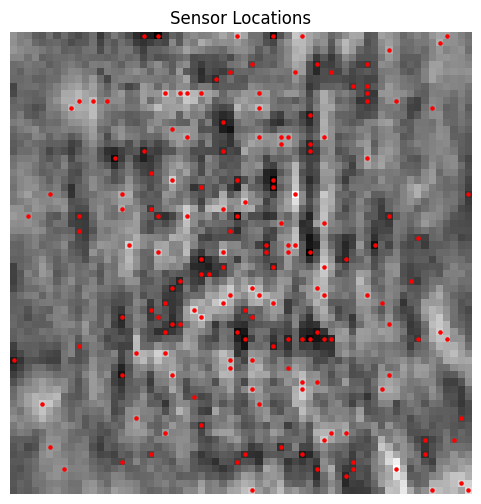

In [ ]:
import cvxpy
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from cvxpy import Variable, Problem, Minimize, norm
import pandas as pd
from tqdm import tqdm
import os


def extract_image_pairs(df, stability_status):
    status_df = df[df['stability'] == stability_status]
    pair_ids = status_df['pair_id'].unique()
    image_pairs = []
    for pair_id in pair_ids:
        pair_images = status_df[status_df['pair_id'] == pair_id]
        wood_image = pair_images[pair_images['image_type'] == 'wood'].iloc[0]
        clinic_image = pair_images[pair_images['image_type'] == 'clinic'].iloc[0]
        image_pairs.append((wood_image, clinic_image))
    return image_pairs


def fuse_images(wood_path, clinic_path, output_path, wood_weight=0.7):
    wood_img = cv2.imread(wood_path, 0)
    clinic_img = cv2.imread(clinic_path, 0)
    if wood_img.shape != clinic_img.shape:
        clinic_img = cv2.resize(clinic_img, (wood_img.shape[1], wood_img.shape[0]))
    fused_img = cv2.addWeighted(wood_img, wood_weight, clinic_img, 1 - wood_weight, 0)
    #fused_img, _ = RPCA(fused_img)
    fused_img = cv2.resize(fused_img, (64, 64))
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, fused_img)
    return fused_img

def SSPOC(Psi, w, lambda_=0, epsilon=1e-10):
    """
    Solve sparse sensor placement optimization problem
    """
    n, r = Psi.shape
    c = w.shape[1]

    s = Variable((n, c))
    objective = Minimize(norm(s, 1) + lambda_ * norm(s @ np.ones(c), 1))
    constraints = [norm(Psi.T @ s - w, 'fro') <= epsilon]
    prob = Problem(objective, constraints)
    
    try:
        prob.solve(solver='ECOS')
    except:
        prob.solve(solver='SCS')
    
    if prob.status == 'optimal':
        return s.value
    else:
        print(f"优化状态: {prob.status}")
        return np.zeros((n, c))
    
def load_data(file_path):
    return pd.read_csv(file_path)
df = load_data('../../../datasets/data.csv')
stable_pairs = extract_image_pairs(df, 'stable')
non_stable_pairs = extract_image_pairs(df, 'non-stable')
output_dir = 'fused_images'
stable_images, non_stable_images = [], []
for wood, clinic in tqdm(stable_pairs, desc="融合稳定期图像"):
    path = os.path.join(output_dir, f"stable_{wood['pair_id']}.jpg")
    fuse_images(wood['image_path'], clinic['image_path'], path)
    stable_images.append((path, 0))
for wood, clinic in tqdm(non_stable_pairs, desc="融合进展期图像"):
    path = os.path.join(output_dir, f"non-stable_{wood['pair_id']}.jpg")
    fuse_images(wood['image_path'], clinic['image_path'], path)
    non_stable_images.append((path, 1))
all_images = stable_images + non_stable_images
X, y = [], []
for img_path, label in all_images:
    img = cv2.imread(img_path, 0).flatten()
    #print(img.shape)

    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)
pca = PCA(n_components=0.95) 
X_pca = pca.fit_transform(X)

lda = LDA()
w = lda.fit(X_pca, y).coef_.T  
print(w.shape)

n = X.shape[1]  
Psi_r = pca.components_.T 

s = SSPOC(Psi_r, w)



c = w.shape[1]
r = w.shape[0]
threshold = np.linalg.norm(s, 'fro') / (c * r * 2)
sensors = np.where(np.abs(s) >= threshold)[0]
# sensor_image = np.ones((64, 64), dtype=np.uint8) * 255
chi = -Psi_r @ w
sensor_image = chi.reshape(64, 64)
plt.figure(figsize=(6, 6))
plt.imshow(sensor_image, cmap='gray')
plt.scatter(sensors % 64, sensors // 64, color='red', s=5)  
plt.title('Sensor Locations')
plt.axis('off') 
plt.show()

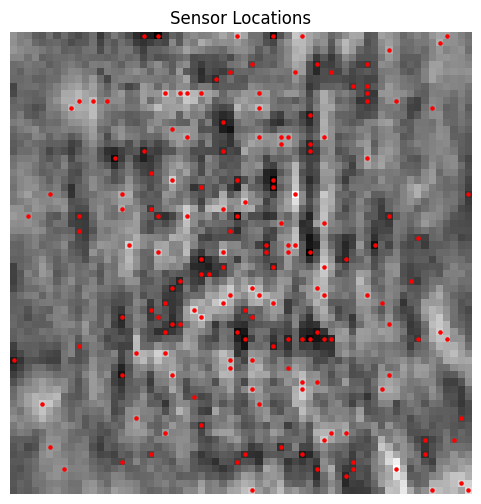

In [21]:
c = w.shape[1]
r = w.shape[0]
threshold = np.linalg.norm(s, 'fro') / (c * r * 2)
sensors = np.where(np.abs(s) >= threshold)[0]
# sensor_image = np.ones((64, 64), dtype=np.uint8) * 255
chi = -Psi_r @ w
sensor_image = chi.reshape(64, 64)
plt.figure(figsize=(6, 6))
plt.imshow(sensor_image, cmap='gray')
plt.scatter(sensors % 64, sensors // 64, color='red', s=5)  
plt.title('Sensor Locations')
plt.axis('off') 
plt.show()

融合稳定期图像: 100%|██████████| 307/307 [00:00<00:00, 2072.20it/s]


跳过融合: fused_images\stable_1.jpg 已存在
跳过融合: fused_images\stable_2.jpg 已存在
跳过融合: fused_images\stable_3.jpg 已存在
跳过融合: fused_images\stable_4.jpg 已存在
跳过融合: fused_images\stable_5.jpg 已存在
跳过融合: fused_images\stable_6.jpg 已存在
跳过融合: fused_images\stable_7.jpg 已存在
跳过融合: fused_images\stable_8.jpg 已存在
跳过融合: fused_images\stable_9.jpg 已存在
跳过融合: fused_images\stable_10.jpg 已存在
跳过融合: fused_images\stable_11.jpg 已存在
跳过融合: fused_images\stable_12.jpg 已存在
跳过融合: fused_images\stable_13.jpg 已存在
跳过融合: fused_images\stable_14.jpg 已存在
跳过融合: fused_images\stable_15.jpg 已存在
跳过融合: fused_images\stable_16.jpg 已存在
跳过融合: fused_images\stable_17.jpg 已存在
跳过融合: fused_images\stable_18.jpg 已存在
跳过融合: fused_images\stable_19.jpg 已存在
跳过融合: fused_images\stable_20.jpg 已存在
跳过融合: fused_images\stable_21.jpg 已存在
跳过融合: fused_images\stable_22.jpg 已存在
跳过融合: fused_images\stable_23.jpg 已存在
跳过融合: fused_images\stable_24.jpg 已存在
跳过融合: fused_images\stable_25.jpg 已存在
跳过融合: fused_images\stable_26.jpg 已存在
跳过融合: fused_images\stable_27.jpg 已存在
跳过融合: fuse

融合进展期图像:   0%|          | 0/298 [00:00<?, ?it/s]

跳过融合: fused_images\non-stable_1.jpg 已存在
跳过融合: fused_images\non-stable_2.jpg 已存在
跳过融合: fused_images\non-stable_3.jpg 已存在
跳过融合: fused_images\non-stable_4.jpg 已存在
跳过融合: fused_images\non-stable_5.jpg 已存在
跳过融合: fused_images\non-stable_6.jpg 已存在
跳过融合: fused_images\non-stable_7.jpg 已存在
跳过融合: fused_images\non-stable_8.jpg 已存在
跳过融合: fused_images\non-stable_9.jpg 已存在
跳过融合: fused_images\non-stable_10.jpg 已存在
跳过融合: fused_images\non-stable_11.jpg 已存在
跳过融合: fused_images\non-stable_12.jpg 已存在
跳过融合: fused_images\non-stable_13.jpg 已存在
跳过融合: fused_images\non-stable_14.jpg 已存在
跳过融合: fused_images\non-stable_15.jpg 已存在
跳过融合: fused_images\non-stable_16.jpg 已存在
跳过融合: fused_images\non-stable_17.jpg 已存在
跳过融合: fused_images\non-stable_18.jpg 已存在
跳过融合: fused_images\non-stable_19.jpg 已存在
跳过融合: fused_images\non-stable_20.jpg 已存在
跳过融合: fused_images\non-stable_21.jpg 已存在
跳过融合: fused_images\non-stable_22.jpg 已存在
跳过融合: fused_images\non-stable_23.jpg 已存在
跳过融合: fused_images\non-stable_24.jpg 已存在
跳过融合: fused_images\non-st

融合进展期图像: 100%|██████████| 298/298 [00:00<00:00, 2259.87it/s]


跳过融合: fused_images\non-stable_112.jpg 已存在
跳过融合: fused_images\non-stable_113.jpg 已存在
跳过融合: fused_images\non-stable_114.jpg 已存在
跳过融合: fused_images\non-stable_115.jpg 已存在
跳过融合: fused_images\non-stable_116.jpg 已存在
跳过融合: fused_images\non-stable_117.jpg 已存在
跳过融合: fused_images\non-stable_118.jpg 已存在
跳过融合: fused_images\non-stable_119.jpg 已存在
跳过融合: fused_images\non-stable_120.jpg 已存在
跳过融合: fused_images\non-stable_121.jpg 已存在
跳过融合: fused_images\non-stable_122.jpg 已存在
跳过融合: fused_images\non-stable_123.jpg 已存在
跳过融合: fused_images\non-stable_124.jpg 已存在
跳过融合: fused_images\non-stable_125.jpg 已存在
跳过融合: fused_images\non-stable_126.jpg 已存在
跳过融合: fused_images\non-stable_127.jpg 已存在
跳过融合: fused_images\non-stable_128.jpg 已存在
跳过融合: fused_images\non-stable_129.jpg 已存在
跳过融合: fused_images\non-stable_130.jpg 已存在
跳过融合: fused_images\non-stable_131.jpg 已存在
跳过融合: fused_images\non-stable_132.jpg 已存在
跳过融合: fused_images\non-stable_133.jpg 已存在
跳过融合: fused_images\non-stable_134.jpg 已存在
跳过融合: fused_images\non-stable_135.

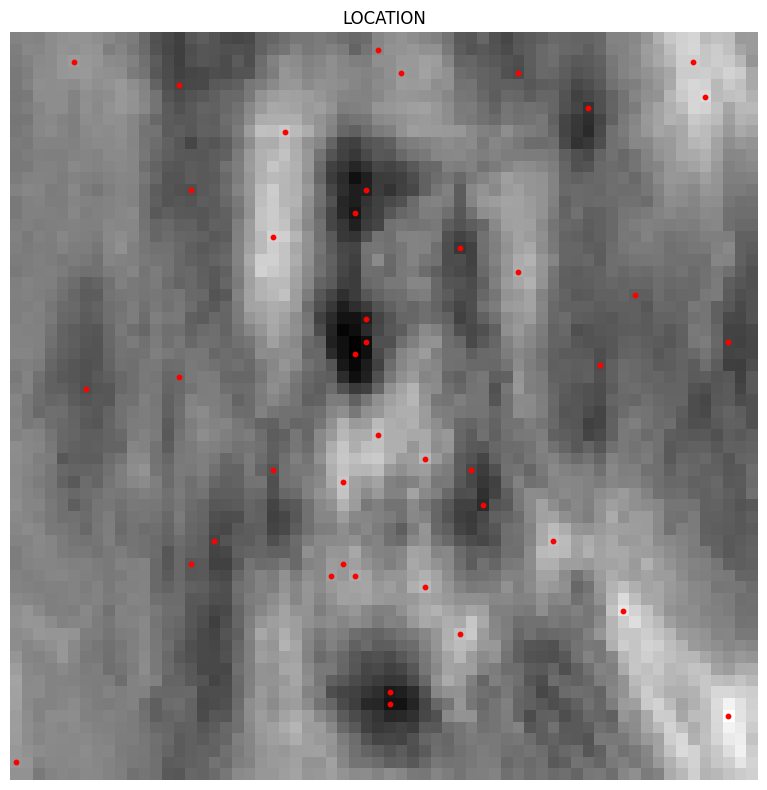

使用42个稀疏传感器的分类准确率: 0.5659


In [ ]:
import cvxpy
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from cvxpy import Variable, Problem, Minimize, norm
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

def extract_image_pairs(df, stability_status):

    status_df = df[df['stability'] == stability_status]
    pair_ids = status_df['pair_id'].unique()
    image_pairs = []
    for pair_id in pair_ids:
        pair_images = status_df[status_df['pair_id'] == pair_id]
        wood_image = pair_images[pair_images['image_type'] == 'wood'].iloc[0]
        clinic_image = pair_images[pair_images['image_type'] == 'clinic'].iloc[0]
        image_pairs.append((wood_image, clinic_image))
    return image_pairs

def fuse_images(wood_path, clinic_path, output_path, wood_weight=0.7):


    if os.path.exists(output_path):
        print(f"跳过融合: {output_path} 已存在")
        return cv2.imread(output_path, 0)
    
    wood_img = cv2.imread(wood_path, 0)
    clinic_img = cv2.imread(clinic_path, 0)
    

    if wood_img.shape != clinic_img.shape:
        clinic_img = cv2.resize(clinic_img, (wood_img.shape[1], wood_img.shape[0]))
    

    fused_img = cv2.addWeighted(wood_img, wood_weight, clinic_img, 1 - wood_weight, 0)
    

    fused_img = cv2.resize(fused_img, (64, 64))
    

    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, fused_img)
    
    return fused_img

def SSPOC(Psi, w, lambda_=0, epsilon=1e-10):

    n, r = Psi.shape
    c = w.shape[1]


    s = Variable((n, c))
    objective = Minimize(norm(s, 1) + lambda_ * norm(s @ np.ones(c), 1))
    constraints = [norm(Psi.T @ s - w, 'fro') <= epsilon]
    prob = Problem(objective, constraints)
    
    try:
        prob.solve(solver='ECOS')
        print('using ECOS')
    except:
        prob.solve(solver='SCS')
        print('using SCS')
    
    if prob.status == 'optimal':
        print('Optimal solution  found')
        return s.value
    else:
        print(f"优化状态: {prob.status}，使用零矩阵作为替代")
        return np.zeros((n, c))
    
def load_data(file_path):

    return pd.read_csv(file_path)

def main():
    df = load_data('../../../datasets/data.csv')
    stable_pairs = extract_image_pairs(df, 'stable')
    non_stable_pairs = extract_image_pairs(df, 'non-stable')
    
    output_dir = 'fused_images'
    stable_images, non_stable_images = [], []

    for wood, clinic in tqdm(stable_pairs, desc="融合稳定期图像"):
        path = os.path.join(output_dir, f"stable_{wood['pair_id']}.jpg")
        fused_img = fuse_images(wood['image_path'], clinic['image_path'], path)
        stable_images.append((path, 0))
    

    for wood, clinic in tqdm(non_stable_pairs, desc="融合进展期图像"):
        path = os.path.join(output_dir, f"non-stable_{wood['pair_id']}.jpg")
        fused_img = fuse_images(wood['image_path'], clinic['image_path'], path)
        non_stable_images.append((path, 1))
    

    all_images = stable_images + non_stable_images
    X, y = [], []
    
    for img_path, label in all_images:
        img = cv2.imread(img_path, 0).flatten()
        X.append(img)
        y.append(label)
    
    X = np.array(X)
    y = np.array(y)
    print(f"特征矩阵形状: {X.shape}, 标签形状: {y.shape}")
    

    pca = PCA(n_components=50) 
    X_pca = pca.fit_transform(X)
    print(f"PCA后特征形状: {X_pca.shape}")
    print(f"保留的主成分数量: {pca.n_components_}")
    

    lda = LDA()
    lda.fit(X_pca, y)
    w = lda.coef_.T 
    print(f"LDA投影矩阵形状: {w.shape}")
    

    n = X.shape[1]
    Psi_r = pca.components_.T  
    print(f"特征基矩阵形状: {Psi_r.shape}")
    
 
    s = SSPOC(Psi_r, w)
    

    c = w.shape[1]
    r = w.shape[0]
    threshold = np.mean(np.abs(s)) + 1 * np.std(np.abs(s))
    sensors = np.where(np.abs(s) >= threshold)[0]
    print(f"选择的传感器数量: {len(sensors)}")
    
 
    chi = -Psi_r @ w
    sensor_image = chi.reshape(64, 64)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(sensor_image, cmap='gray')
    plt.scatter(sensors % 64, sensors // 64, color='red', s=10)  
    plt.title('LOCATION')
    plt.axis('off') 
    plt.tight_layout()
    plt.savefig('sensor_locations.png', dpi=300)
    plt.show()
    

    q = len(sensors)
    Phi = np.zeros((q, n))
    for qi in range(q):
        Phi[qi, sensors[qi]] = 1
    

    X_sparse = Phi @ X.T
    X_sparse = X_sparse.T
    

    X_train, X_test, y_train, y_test = train_test_split(
        X_sparse, y, test_size=0.3, random_state=42
    )
    

    clf = LogisticRegression(max_iter=1000)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"使用{q}个稀疏传感器的分类准确率: {accuracy:.4f}")

if __name__ == "__main__":
    main()

Fusing stable images: 100%|██████████| 307/307 [00:00<00:00, 2257.22it/s]


Skipping fusion: fused_images\stable_1.jpg already exists
Skipping fusion: fused_images\stable_2.jpg already exists
Skipping fusion: fused_images\stable_3.jpg already exists
Skipping fusion: fused_images\stable_4.jpg already exists
Skipping fusion: fused_images\stable_5.jpg already exists
Skipping fusion: fused_images\stable_6.jpg already exists
Skipping fusion: fused_images\stable_7.jpg already exists
Skipping fusion: fused_images\stable_8.jpg already exists
Skipping fusion: fused_images\stable_9.jpg already exists
Skipping fusion: fused_images\stable_10.jpg already exists
Skipping fusion: fused_images\stable_11.jpg already exists
Skipping fusion: fused_images\stable_12.jpg already exists
Skipping fusion: fused_images\stable_13.jpg already exists
Skipping fusion: fused_images\stable_14.jpg already exists
Skipping fusion: fused_images\stable_15.jpg already exists
Skipping fusion: fused_images\stable_16.jpg already exists
Skipping fusion: fused_images\stable_17.jpg already exists
Skippi

Fusing non-stable images:   0%|          | 0/298 [00:00<?, ?it/s]

Skipping fusion: fused_images\non-stable_1.jpg already exists
Skipping fusion: fused_images\non-stable_2.jpg already exists
Skipping fusion: fused_images\non-stable_3.jpg already exists
Skipping fusion: fused_images\non-stable_4.jpg already exists
Skipping fusion: fused_images\non-stable_5.jpg already exists
Skipping fusion: fused_images\non-stable_6.jpg already exists
Skipping fusion: fused_images\non-stable_7.jpg already exists
Skipping fusion: fused_images\non-stable_8.jpg already exists
Skipping fusion: fused_images\non-stable_9.jpg already exists
Skipping fusion: fused_images\non-stable_10.jpg already exists
Skipping fusion: fused_images\non-stable_11.jpg already exists
Skipping fusion: fused_images\non-stable_12.jpg already exists
Skipping fusion: fused_images\non-stable_13.jpg already exists
Skipping fusion: fused_images\non-stable_14.jpg already exists
Skipping fusion: fused_images\non-stable_15.jpg already exists
Skipping fusion: fused_images\non-stable_16.jpg already exists
S

Fusing non-stable images: 100%|██████████| 298/298 [00:00<00:00, 2274.80it/s]


Skipping fusion: fused_images\non-stable_135.jpg already exists
Skipping fusion: fused_images\non-stable_136.jpg already exists
Skipping fusion: fused_images\non-stable_137.jpg already exists
Skipping fusion: fused_images\non-stable_138.jpg already exists
Skipping fusion: fused_images\non-stable_139.jpg already exists
Skipping fusion: fused_images\non-stable_140.jpg already exists
Skipping fusion: fused_images\non-stable_141.jpg already exists
Skipping fusion: fused_images\non-stable_142.jpg already exists
Skipping fusion: fused_images\non-stable_143.jpg already exists
Skipping fusion: fused_images\non-stable_144.jpg already exists
Skipping fusion: fused_images\non-stable_145.jpg already exists
Skipping fusion: fused_images\non-stable_146.jpg already exists
Skipping fusion: fused_images\non-stable_147.jpg already exists
Skipping fusion: fused_images\non-stable_148.jpg already exists
Skipping fusion: fused_images\non-stable_149.jpg already exists
Skipping fusion: fused_images\non-stable

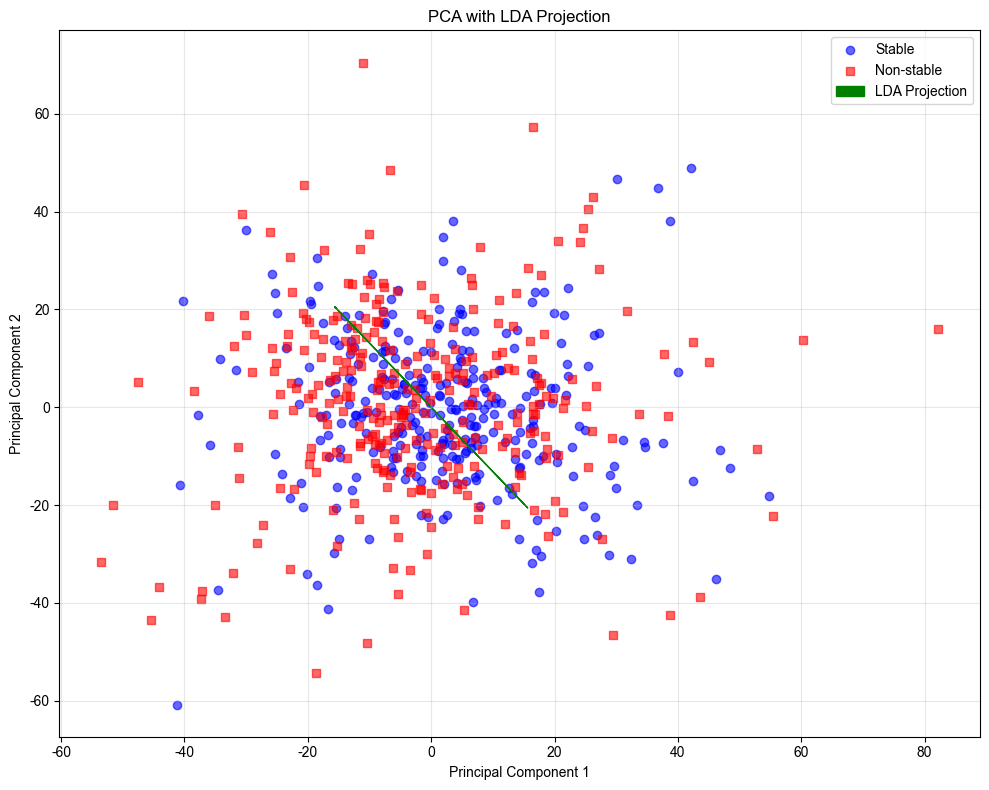

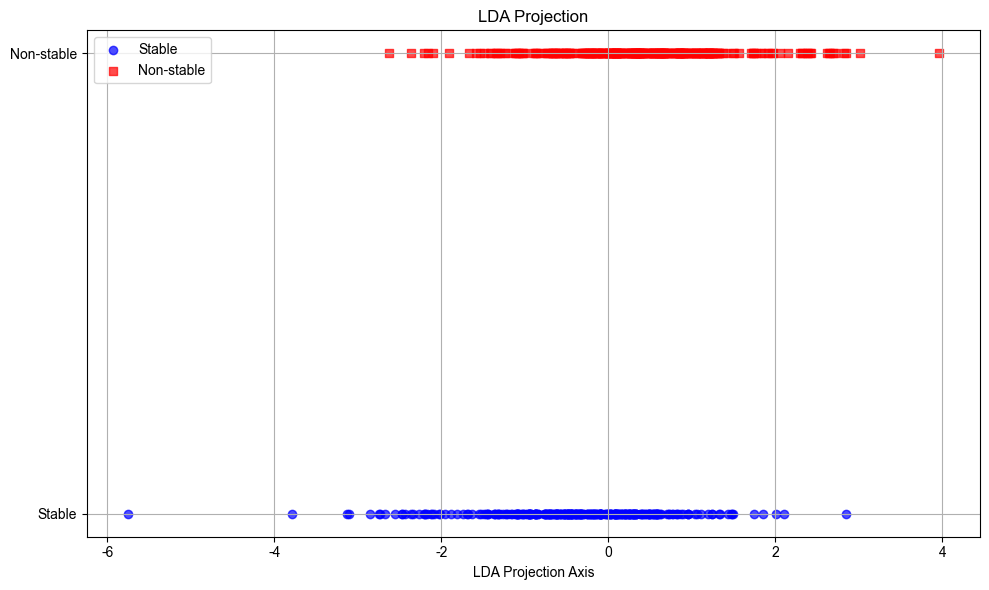

Feature basis matrix shape: (4096, 50)
Using SCS solver
Optimal solution found
[[0]
 [0]]
Number of selected sensors: 33


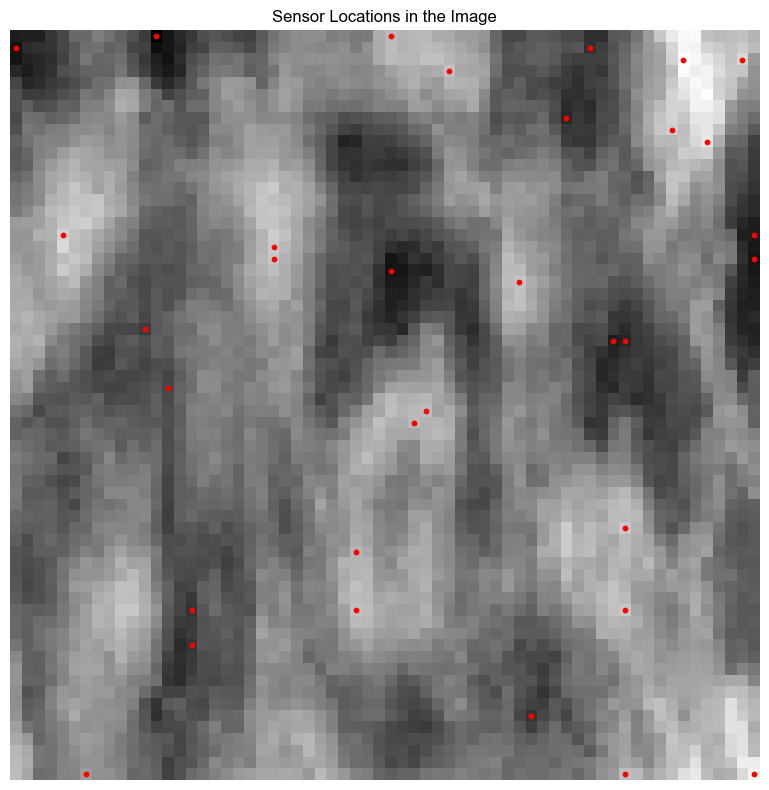

Classification accuracy using 33 sparse sensors: 0.6593


In [ ]:
import cvxpy
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from cvxpy import Variable, Problem, Minimize, norm
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = ["Arial", "sans-serif"]
plt.rcParams["axes.unicode_minus"] = False

def extract_image_pairs(df, stability_status):
    status_df = df[df['stability'] == stability_status]
    pair_ids = status_df['pair_id'].unique()
    image_pairs = []
    for pair_id in pair_ids:
        pair_images = status_df[status_df['pair_id'] == pair_id]
        wood_image = pair_images[pair_images['image_type'] == 'wood'].iloc[0]
        clinic_image = pair_images[pair_images['image_type'] == 'clinic'].iloc[0]
        image_pairs.append((wood_image, clinic_image))
    return image_pairs

def fuse_images(wood_path, clinic_path, output_path, wood_weight=0.7):
    if os.path.exists(output_path):
        print(f"Skipping fusion: {output_path} already exists")
        return cv2.imread(output_path, 0)
    
    wood_img = cv2.imread(wood_path, 0)
    clinic_img = cv2.imread(clinic_path, 0)
    
    if wood_img.shape != clinic_img.shape:
        clinic_img = cv2.resize(clinic_img, (wood_img.shape[1], wood_img.shape[0]))
    
    fused_img = cv2.addWeighted(wood_img, wood_weight, clinic_img, 1 - wood_weight, 0)
    fused_img = cv2.resize(fused_img, (64, 64))
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, fused_img)
    
    return fused_img

def SSPOC(Psi, w, lambda_=0, epsilon=1e-10):
    n, r = Psi.shape
    c = w.shape[1]

    s = Variable((n, c))
    objective = Minimize(norm(s, 1) + lambda_ * norm(s @ np.ones(c), 1))
    constraints = [norm(Psi.T @ s - w, 'fro') <= epsilon]
    prob = Problem(objective, constraints)
    
    try:
        prob.solve(solver='ECOS')
        print('Using ECOS solver')
    except:
        prob.solve(solver='SCS')
        print('Using SCS solver')
    
    if prob.status == 'optimal':
        print('Optimal solution found')
        return s.value
    else:
        print(f"Optimization status: {prob.status}, using zero matrix as substitute")
        return np.zeros((n, c))
    
def load_data(file_path):
    return pd.read_csv(file_path)

def visualize_pca_lda(X_pca, lda_coef, y, title="PCA with LDA Projection"):
    """在PCA可视化上叠加LDA投影方向"""
    plt.figure(figsize=(10, 8))

    class0 = X_pca[y == 0]
    class1 = X_pca[y == 1]
    
    plt.scatter(class0[:, 2], class0[:, 3], c='blue', marker='o', label='Stable', alpha=0.6)
    plt.scatter(class1[:, 2], class1[:, 3], c='red', marker='s', label='Non-stable', alpha=0.6)

    lda_direction = lda_coef.squeeze()
    origin = np.mean(X_pca, axis=0)

    scale = max(np.ptp(X_pca[:, 2]), np.ptp(X_pca[:, 3])) * 30
    arrow_start = origin - lda_direction * scale
    arrow_end = origin + lda_direction * scale

    plt.arrow(arrow_start[0], arrow_start[1], 
              arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1],
              color='green', width=0.02, head_width=0.2, head_length=0.3,
              length_includes_head=True, label='LDA Projection')

    if len(lda_direction) == 2:
        w, b = lda_direction[0], lda_direction[1]
        x_min, x_max = plt.xlim()
        y_min, y_max = plt.ylim()
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
        decision_boundary = w * xx + b * yy
        plt.contour(xx, yy, decision_boundary, levels=[0], colors='black', linestyles='--', alpha=0.7)
    
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('pca_lda_visualization.png', dpi=300)
    plt.show()

def visualize_lda(X, y, title="LDA Projection"):
    lda = LDA(n_components=1)  
    X_lda = lda.fit_transform(X, y)
    
    plt.figure(figsize=(10, 6))
    
    class0 = X_lda[y == 0]
    class1 = X_lda[y == 1]
    
    plt.scatter(class0, np.zeros_like(class0), c='blue', marker='o', label='Stable', alpha=0.7)
    plt.scatter(class1, np.ones_like(class1), c='red', marker='s', label='Non-stable', alpha=0.7)
    
    plt.title(title)
    plt.xlabel('LDA Projection Axis')
    plt.yticks([0, 1], ['Stable', 'Non-stable'])
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('lda_visualization.png', dpi=300)
    plt.show()

    return lda, X_lda


df = load_data('../../../datasets/data.csv')

stable_pairs = extract_image_pairs(df, 'stable')
non_stable_pairs = extract_image_pairs(df, 'non-stable')

output_dir = 'fused_images'
stable_images, non_stable_images = [], []

for wood, clinic in tqdm(stable_pairs, desc="Fusing stable images"):
    path = os.path.join(output_dir, f"stable_{wood['pair_id']}.jpg")
    fused_img = fuse_images(wood['image_path'], clinic['image_path'], path)
    stable_images.append((path, 0))

for wood, clinic in tqdm(non_stable_pairs, desc="Fusing non-stable images"):
    path = os.path.join(output_dir, f"non-stable_{wood['pair_id']}.jpg")
    fused_img = fuse_images(wood['image_path'], clinic['image_path'], path)
    non_stable_images.append((path, 1))

all_images = stable_images + non_stable_images
X, y = [], []

for img_path, label in all_images:
    img = cv2.imread(img_path, 0).flatten()
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)
print(f"Feature matrix shape: {X.shape}, Label shape: {y.shape}")

scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

pca = PCA(n_components=50) 
X_pca = pca.fit_transform(X_standardized)
print(f"PCA feature shape: {X_pca.shape}")
print(f"Number of principal components retained: {pca.n_components_}")

lda = LDA()
lda.fit(X_pca, y)
w = lda.coef_.T 
print(f"LDA projection matrix shape: {w.shape}")

visualize_pca_lda(X_pca, lda.coef_, y)

lda_model, X_lda = visualize_lda(X_pca, y)

n = X.shape[1]
Psi_r = pca.components_.T 
print(f"Feature basis matrix shape: {Psi_r.shape}")

s = SSPOC(Psi_r, w)
top_k = np.argsort(-np.abs(s))[:2]
print(top_k)

c = w.shape[1]
r = w.shape[0]
threshold = np.mean(np.abs(s)) + 2 * np.std(np.abs(s))
sensors = np.where(np.abs(s) >= threshold)[0]
print(f"Number of selected sensors: {len(sensors)}")

chi = -Psi_r @ w
sensor_image = chi.reshape(64, 64)

plt.figure(figsize=(8, 8))
plt.imshow(sensor_image, cmap='gray')
plt.scatter(sensors % 64, sensors // 64, color='red', s=10)  
plt.title('Sensor Locations in the Image')
plt.xlabel('Column Coordinate')
plt.ylabel('Row Coordinate')
plt.axis('off') 
plt.tight_layout()
plt.savefig('sensor_locations.png', dpi=300)
plt.show()

q = len(sensors)
Phi = np.zeros((q, n))
for qi in range(q):
    Phi[qi, sensors[qi]] = 1

X_sparse = Phi @ X.T
X_sparse = X_sparse.T

X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y, test_size=0.3, random_state=42
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy using {q} sparse sensors: {accuracy:.4f}")



Fusing non-stable images: 100%|██████████| 298/298 [00:00<00:00, 2438.46it/s]


Feature matrix shape: (605, 4096), Label shape: (605,)
PCA feature shape: (605, 50)
Number of principal components retained: 50
最优主成分对: PC3 和 PC5, 平均类间距离: 5.3083
LDA projection matrix shape: (1, 50)


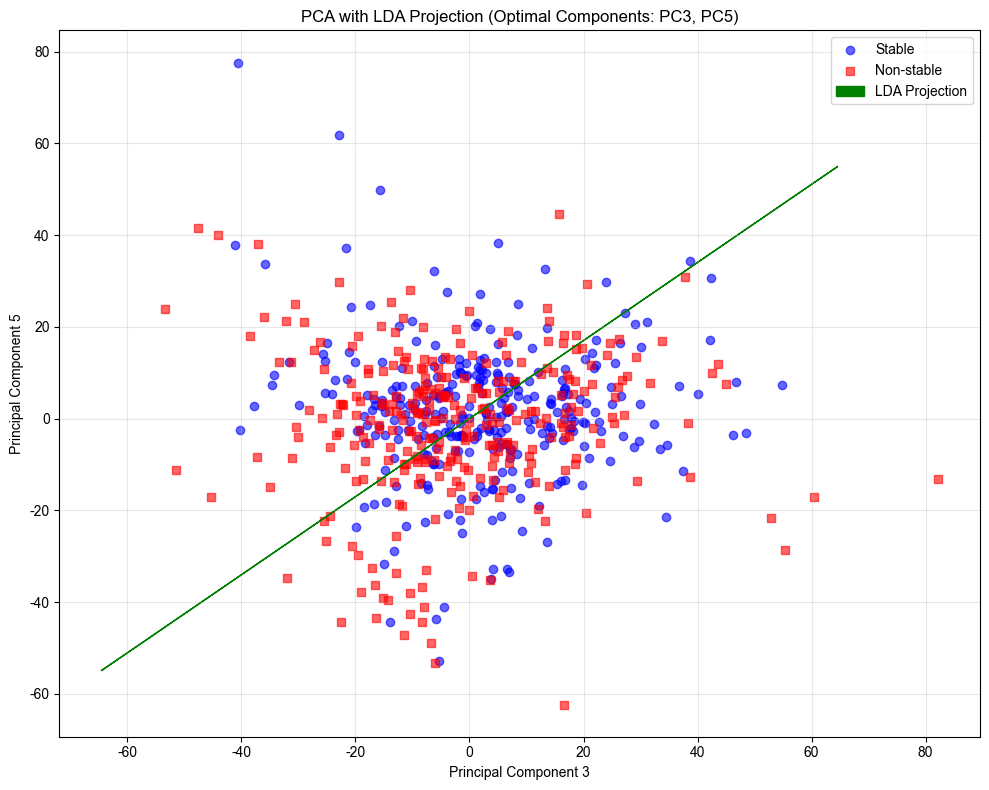

Feature basis matrix shape: (4096, 50)
Using SCS solver
Optimal solution found
Number of selected sensors: 32


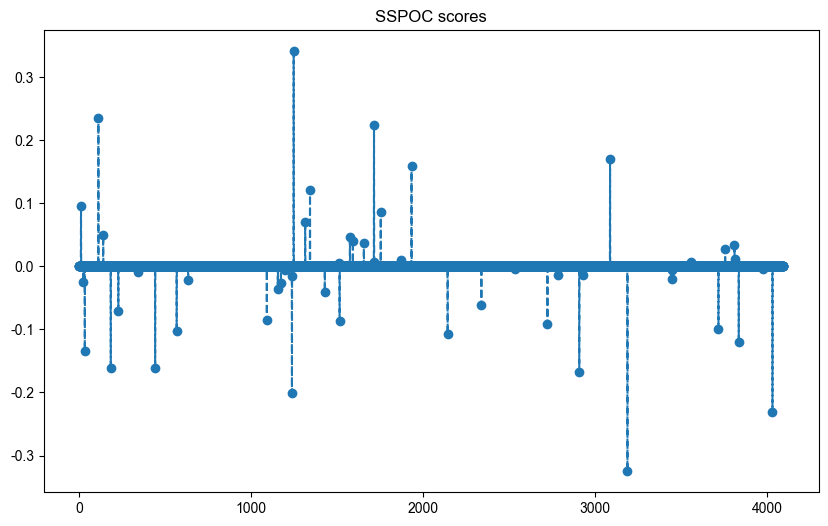

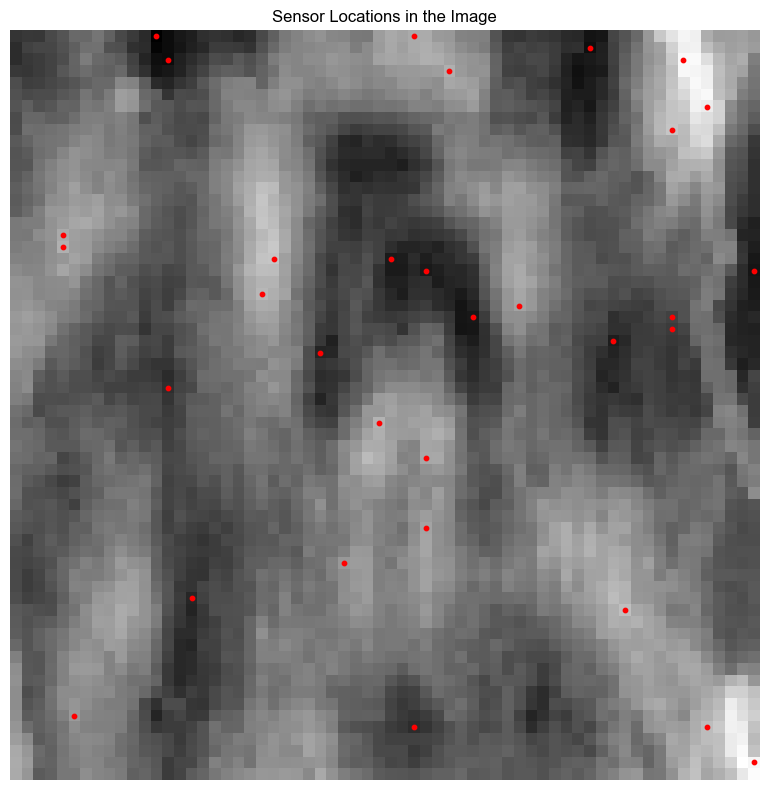

Classification accuracy using 32 sparse sensors: 0.6374


In [ ]:
import cvxpy
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from cvxpy import Variable, Problem, Minimize, norm
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

plt.rcParams["font.family"] = ["Arial", "sans-serif"]
plt.rcParams["axes.unicode_minus"] = False

def extract_image_pairs(df, stability_status):
    status_df = df[df['stability'] == stability_status]
    pair_ids = status_df['pair_id'].unique()
    image_pairs = []
    for pair_id in pair_ids:
        pair_images = status_df[status_df['pair_id'] == pair_id]
        wood_image = pair_images[pair_images['image_type'] == 'wood'].iloc[0]
        clinic_image = pair_images[pair_images['image_type'] == 'clinic'].iloc[0]
        image_pairs.append((wood_image, clinic_image))
    return image_pairs

def fuse_images(wood_path, clinic_path, output_path, wood_weight=0.7):
    if os.path.exists(output_path):

        return cv2.imread(output_path, 0)
    
    wood_img = cv2.imread(wood_path, 0)
    clinic_img = cv2.imread(clinic_path, 0)
    
    if wood_img.shape != clinic_img.shape:
        clinic_img = cv2.resize(clinic_img, (wood_img.shape[1], wood_img.shape[0]))
    
    fused_img = cv2.addWeighted(wood_img, wood_weight, clinic_img, 1 - wood_weight, 0)
    fused_img = cv2.resize(fused_img, (64, 64))
    
    os.makedirs(os.path.dirname(output_path), exist_ok=True)
    cv2.imwrite(output_path, fused_img)
    
    return fused_img

def SSPOC(Psi, w, lambda_=0, epsilon=1e-10):
    n, r = Psi.shape
    c = w.shape[1]

    s = Variable((n, c))
    objective = Minimize(norm(s, 1) + lambda_ * norm(s @ np.ones(c), 1))
    constraints = [norm(Psi.T @ s - w, 'fro') <= epsilon]
    prob = Problem(objective, constraints)
    
    try:
        prob.solve(solver='ECOS')
        print('Using ECOS solver')
    except:
        prob.solve(solver='SCS')
        print('Using SCS solver')
    
    if prob.status == 'optimal':
        print('Optimal solution found')
        return s.value
    else:
        print(f"Optimization status: {prob.status}, using zero matrix as substitute")
        return np.zeros((n, c))
    
def load_data(file_path):
    return pd.read_csv(file_path)

def find_optimal_pca_components(X_pca, y):
    n_components = X_pca.shape[1]
    class_labels = np.unique(y)
    best_pair = (0, 1)
    max_distance = 0
    

    centroids = {}
    for label in class_labels:
        centroids[label] = np.mean(X_pca[y == label], axis=0)
    

    for i in range(n_components):
        for j in range(i+1, n_components):

            pca_pair = X_pca[:, [i, j]]
            
            distances = []
            for label1 in class_labels:
                for label2 in class_labels:
                    if label1 < label2:  
                        dist = np.linalg.norm(centroids[label1][[i, j]] - centroids[label2][[i, j]])
                        distances.append(dist)
            

            avg_distance = np.mean(distances) if distances else 0
            

            if avg_distance > max_distance:
                max_distance = avg_distance
                best_pair = (i, j)
    
    print(f"最优主成分对: PC{best_pair[0]+1} 和 PC{best_pair[1]+1}, 平均类间距离: {max_distance:.4f}")
    return best_pair, max_distance

def visualize_pca_lda(X_pca, lda_coef, y, best_pca_pair):

    i, j = best_pca_pair
    plt.figure(figsize=(10, 8))
    

    X_selected = X_pca[:, [i, j]]
    

    class0 = X_selected[y == 0]
    class1 = X_selected[y == 1]
    
    plt.scatter(class0[:, 0], class0[:, 1], c='blue', marker='o', label='Stable', alpha=0.6)
    plt.scatter(class1[:, 0], class1[:, 1], c='red', marker='s', label='Non-stable', alpha=0.6)
    

    if lda_coef.ndim == 2:
        lda_direction = lda_coef[0, best_pca_pair]  
    else:
        lda_direction = lda_coef[best_pca_pair] 
    
    origin = np.mean(X_selected, axis=0)
    

    scale = max(np.ptp(X_pca[:, 2]), np.ptp(X_pca[:, 3])) * 30
    arrow_start = origin - lda_direction * scale
    arrow_end = origin + lda_direction * scale
    

    plt.arrow(arrow_start[0], arrow_start[1], 
              arrow_end[0] - arrow_start[0], arrow_end[1] - arrow_start[1],
              color='green', width=0.02, head_width=0.2, head_length=0.3,
              length_includes_head=True, label='LDA Projection')
    

   
    
    plt.title(f'PCA with LDA Projection (Optimal Components: PC{i+1}, PC{j+1})')
    plt.xlabel(f'Principal Component {i+1}')
    plt.ylabel(f'Principal Component {j+1}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('optimal_pca_lda_visualization.png', dpi=300)
    plt.show()


n_components = 50
df = load_data('../../../datasets/data.csv')

stable_pairs = extract_image_pairs(df, 'stable')
non_stable_pairs = extract_image_pairs(df, 'non-stable')

output_dir = 'fused_images'
stable_images, non_stable_images = [], []

for wood, clinic in tqdm(stable_pairs, desc="Fusing stable images"):
    path = os.path.join(output_dir, f"stable_{wood['pair_id']}.jpg")
    fused_img = fuse_images(wood['image_path'], clinic['image_path'], path)
    stable_images.append((path, 0))

for wood, clinic in tqdm(non_stable_pairs, desc="Fusing non-stable images"):
    path = os.path.join(output_dir, f"non-stable_{wood['pair_id']}.jpg")
    fused_img = fuse_images(wood['image_path'], clinic['image_path'], path)
    non_stable_images.append((path, 1))

all_images = stable_images + non_stable_images
X, y = [], []

for img_path, label in all_images:
    img = cv2.imread(img_path, 0).flatten()
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)
print(f"Feature matrix shape: {X.shape}, Label shape: {y.shape}")


scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)


pca = PCA(n_components=min(n_components, X.shape[1]-1)) 
X_pca = pca.fit_transform(X_standardized)
print(f"PCA feature shape: {X_pca.shape}")
print(f"Number of principal components retained: {pca.n_components_}")


best_pca_pair, max_dist = find_optimal_pca_components(X_pca, y)


lda = LDA()
lda.fit(X_pca, y)
print(f"LDA projection matrix shape: {lda.coef_.shape}")


visualize_pca_lda(X_pca, lda.coef_, y, best_pca_pair)




n = X.shape[1]
Psi_r = pca.components_.T 
print(f"Feature basis matrix shape: {Psi_r.shape}")


s = SSPOC(Psi_r, lda.coef_.T)
plt.figure(figsize=(10, 6))
plt.plot(s, marker='o', linestyle='--')
plt.title('SSPOC scores')




threshold = np.mean(np.abs(s)) + 2 * np.std(np.abs(s))

sensors = np.where(np.abs(s) > threshold)[0]
print(f"Number of selected sensors: {len(sensors)}")


chi = -Psi_r @ lda.coef_.T
sensor_image = chi.reshape(64, 64)

plt.figure(figsize=(8, 8))
plt.imshow(sensor_image, cmap='gray')
plt.scatter(sensors % 64, sensors // 64, color='red', s=10)  
plt.title('Sensor Locations in the Image')
plt.xlabel('Column Coordinate')
plt.ylabel('Row Coordinate')
plt.axis('off') 
plt.tight_layout()
plt.savefig('sensor_locations.png', dpi=300)
plt.show()


q = len(sensors)
Phi = np.zeros((q, n))
for qi in range(q):
    Phi[qi, sensors[qi]] = 1

X_sparse = Phi @ X.T
X_sparse = X_sparse.T

X_train, X_test, y_train, y_test = train_test_split(
    X_sparse, y, test_size=0.3, random_state=42
)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Classification accuracy using {q} sparse sensors: {accuracy:.4f}")

